In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
from time import time
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [3]:
# graph_file = 'data/graphs/400950-400951_n3.json'
graph_file = 'data/graphs/400360-400361_n3.json'

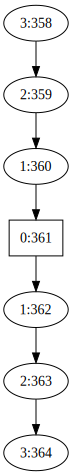

In [5]:
SROUTE, ADJ = read_graph(graph_file, 
                         verbose=False, named_adj=True)
dmap = compute_depth(SROUTE, ADJ)
graph = show_graph(SROUTE, ADJ, vdesc=lambda vert: '%s:%s' % (str(dmap[vert]), vert[-3:]) )

EPS = 16
LAG = 24 + 1
hops = int(graph_file[:-5].split('_n')[1])
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
graph

In [7]:
from models.temporal.RNN import *
from models.MPRNN import *
from models.Variants import *

HSIZE = 128
AUTO_ITER = hops

# model = MPRNN_FCAST(
model = MPRNN_FCAST(
    nodes=SROUTE, adj=ADJ, 

#     rnnmdl=RNN_HDN_LOSSY,
#     mpnmdl=MPN_DEEP_LOSSY,
    
    iters=AUTO_ITER,
    iter_indep=False,
    
    hidden_size=HSIZE, 
    single_mpn=False,
    verbose=True)

model.to(device)
model.device = device
model.hops = hops

MPRNN
 [*] Defined over: 7 nodes
 [*] Contains    : 7 adjs
MPRNN_ITER
iters: 3
indep: False
FCAST
 [*] Fringes: [6, 5]
 [*] RNN: <class 'models.Variants.RNN_HDN'>
 [*] MPN: <class 'models.MPRNN.MP_DENSE'>


In [8]:
criterion, opt, sch = model.params(lr=0.001)

In [16]:
dset = SpotHistory(
    SROUTE, 'train', 32, 
    ignore_missing=True, 
    clip_hours=8, 
    lag=LAG, res=10).generator()
valset = SpotHistory(
    SROUTE, 'test', 32, 
    ignore_missing=True, 
    clip_hours=8, 
    lag=LAG, res=10).generator()
testset = SpotHistory(
    SROUTE, 'test', 18, lag=None, 
    clip_hours=8, res=10, shuffle=False, 
    verbose=False)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400360-400361]: 90
    * [400359-400360]: 90
    * [400361-400362]: 90
    * [400358-400359]: 90
    * [400362-400363]: 90
    * [400363-400364]: 90
    * [400561-400358]: 90
 [*] Examples (train): 4443
 [*] No missing: 4443/4632
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400360-400361]: 90
    * [400359-400360]: 90
    * [400361-400362]: 90
    * [400358-400359]: 90
    * [400362-400363]: 90
    * [400363-400364]: 90
    * [400561-400358]: 90
 [*] Examples (test): 1060
 [*] No missing: 1060/1153
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [11]:
evf = lambda: evaluate(
    valset, model, 
    crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())

In [12]:
best_eval = evf()

Eval loss: 18.1094          


In [13]:
# model.load_prior()
# best_eval = evf()

In [14]:
train_mse = []
eval_mse = []
eval_mape = []

LR 0.001


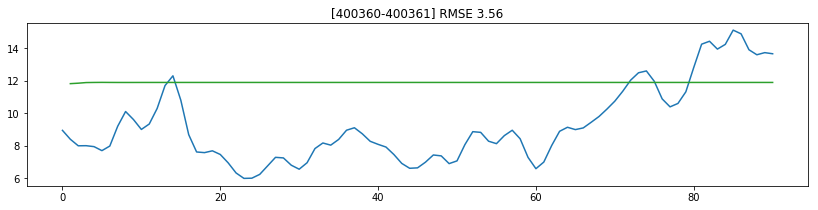

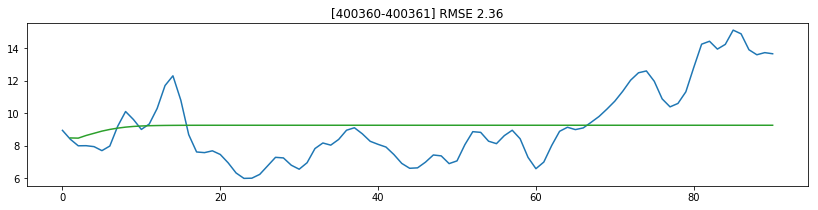

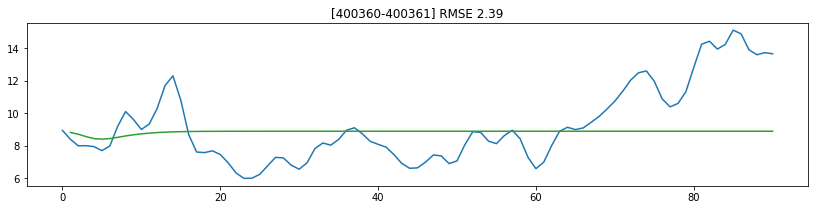

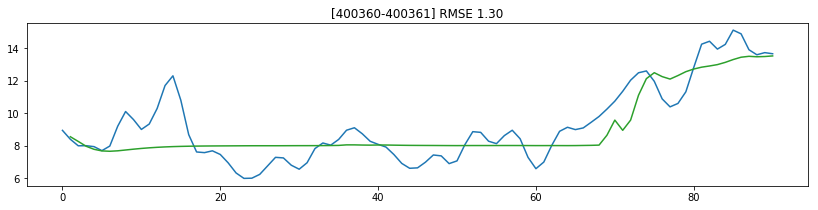

[1/16 : 139/139] - L4.43 (avg 6.80  95.8s)  
Eval loss: 5.6536           
LR 0.001


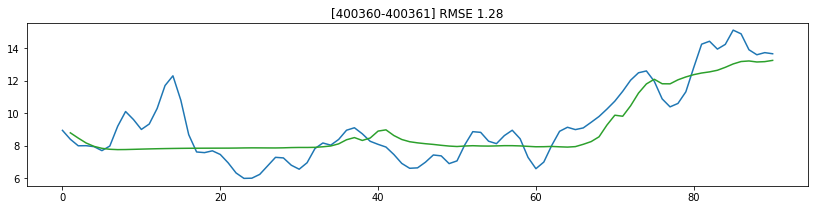

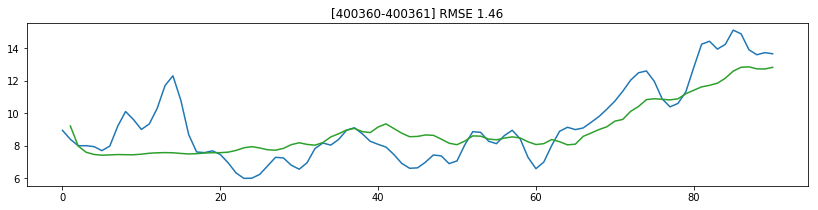

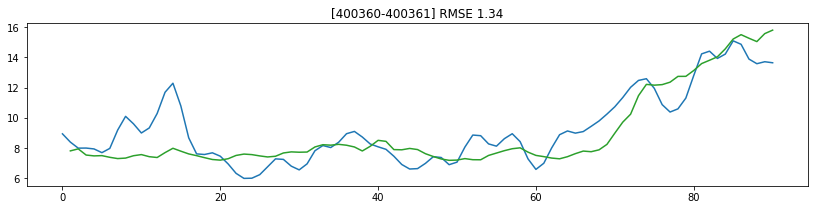

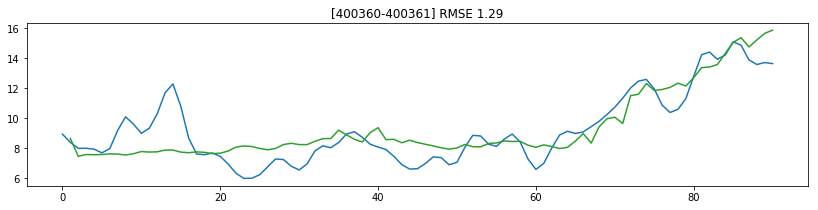

[2/16 : 139/139] - L6.39 (avg 3.80  97.5s)  
Eval loss: 4.9049          
LR 0.001


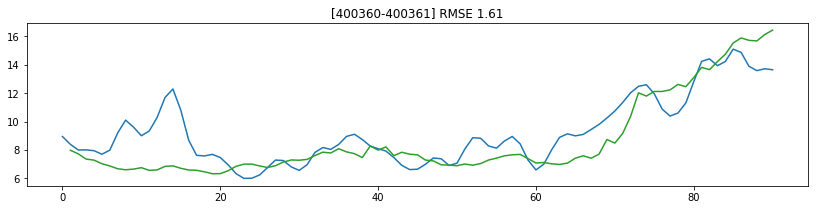

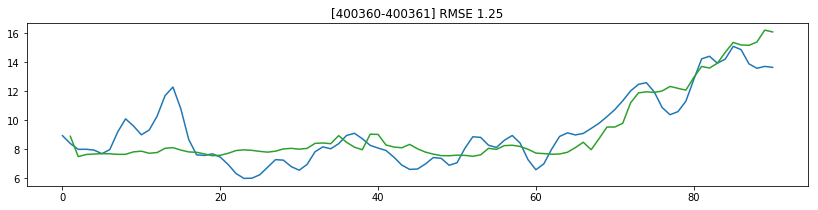

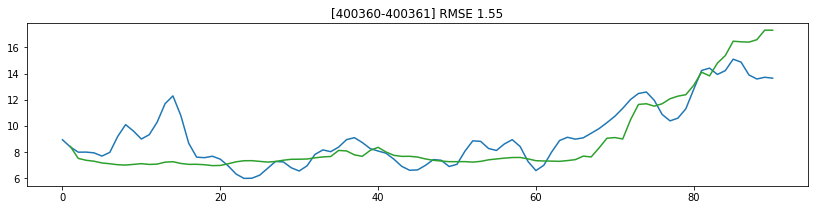

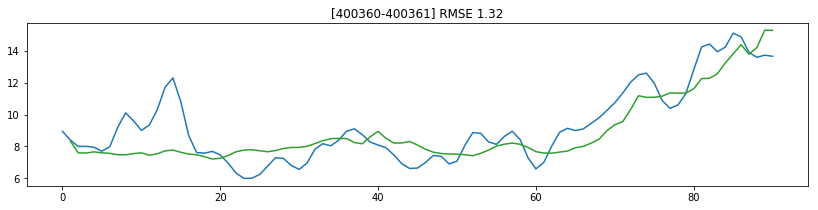

[3/16 : 139/139] - L2.73 (avg 3.46  95.7s)  
Eval loss: 4.8268          
LR 0.001


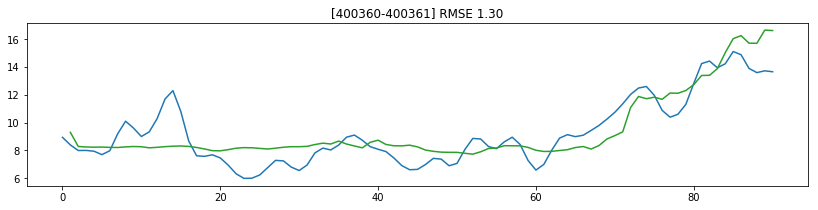

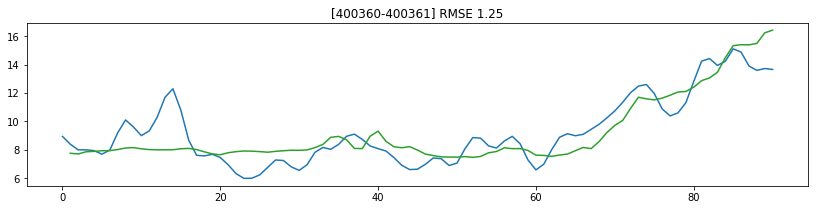

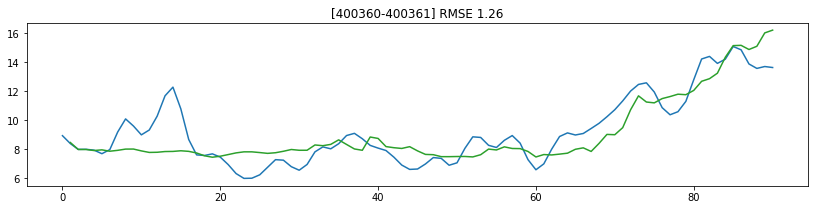

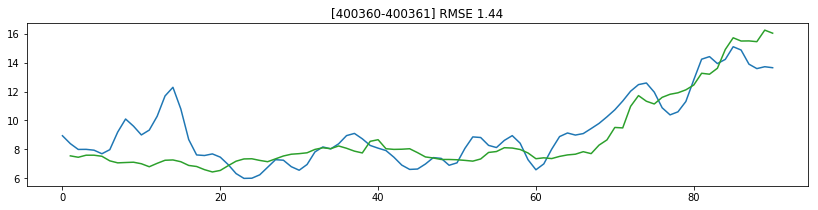

[4/16 : 139/139] - L2.82 (avg 3.37  98.3s)  
Eval loss: 4.3912          
LR 0.001


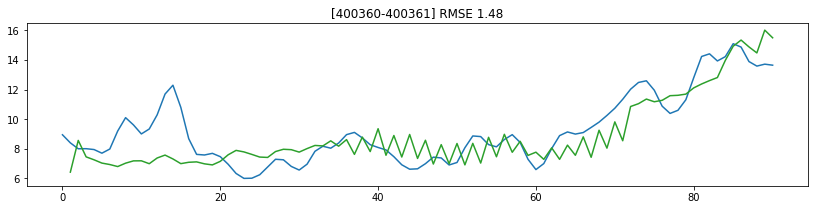

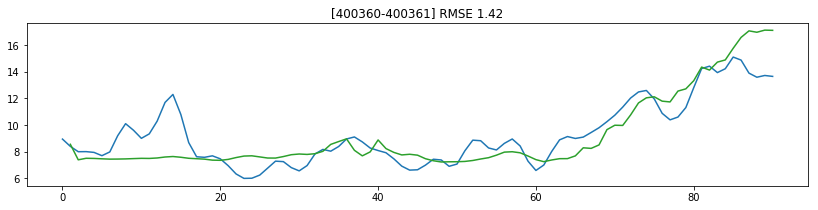

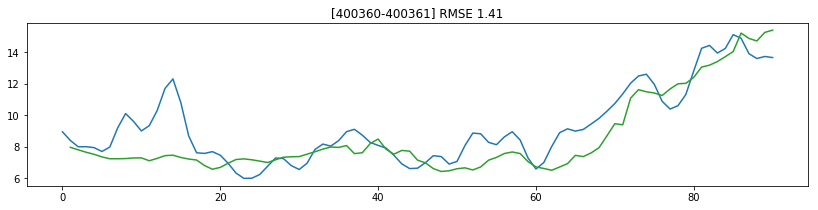

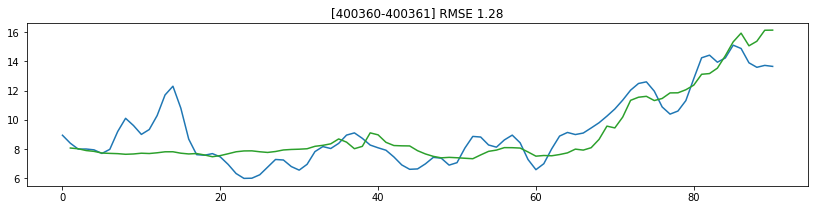

[5/16 : 139/139] - L5.75 (avg 3.49  96.0s)  
Eval loss: 4.5288          
LR 0.001


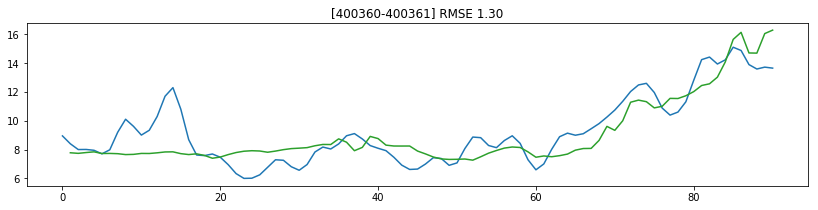

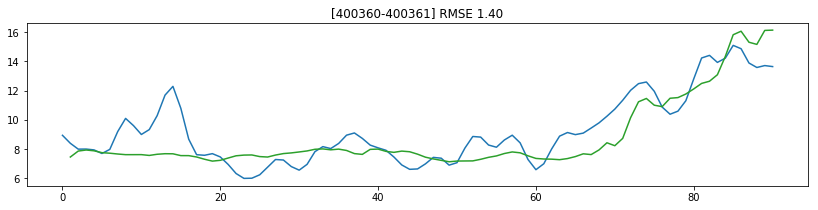

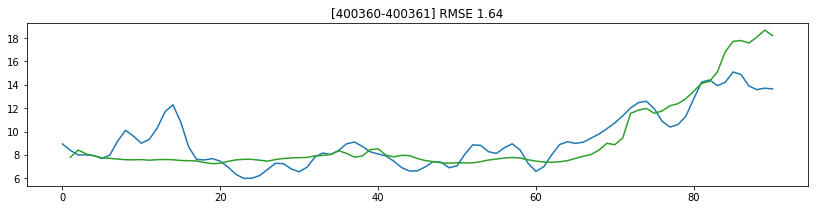

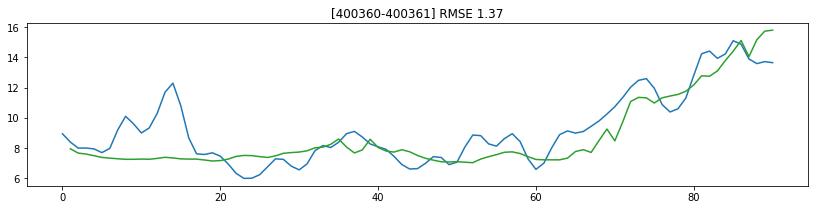

[6/16 : 139/139] - L2.77 (avg 3.31  96.2s)  


In [ ]:
# plotbatch = None
for eii  in range(EPS):
#     sch.step()
    print('LR', get_lr(opt))
    
    bls = []
    t0 = time()
    for bii, batch in enumerate(dset):
        if bii % 40 == 0:
            _ = forecast_mprnn(
                testset[0], model, graph_file, 
                twoway=True,
                explicit=False,
                verbose=False, plot=True)
            
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)
        
        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        opt.step()

        bls.append(loss.item())
        bmse = ''
        if bii == len(dset) - 1:
            bmse = (10 ** 2 * np.mean(bls))
            bmse = '(avg %.2f  %.1fs)' % (bmse, time() - t0)
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s  \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            bmse
        ))
    train_mse += bls
    sys.stdout.write('\n')

    last_eval = evf()
    if last_eval < best_eval:
#         model.save()
        best_eval = last_eval
    eval_mse.append(last_eval)
    
    sys.stdout.flush()

In [12]:
# model.save()

Saving to: /home/ubuntu/datasets-aux/checkpoints/mpfcast/400950-400951_n1.pth


In [17]:
testset = SpotHistory(SROUTE, 'test', 18, lag=LAG, res=10, shuffle=False, verbose=True)

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
    * [400953-405297]: 90
    * [405297-404153]: 90
    * [400861-400948]: 90
 [*] Examples (test): 919
 [*] No missing: 919/1454
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [20]:
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

1 torch.Size([24, 9])


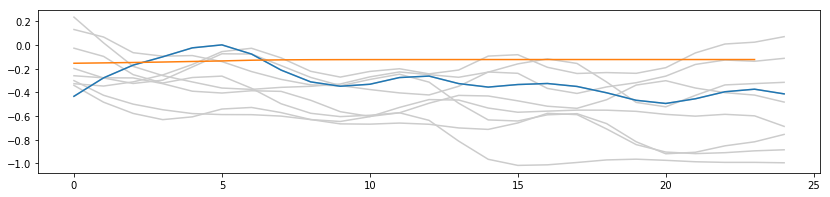

In [34]:
for ii in range(10):
    data = testset[ii]
#     print(data.shape)
    tens = torch.from_numpy(data).to(device).float().unsqueeze(0)
    Xs, _ = model.format_batch(tens)
    yhat = model(Xs)
    print(len(yhat), yhat[0].size())
    
    plt.figure(figsize=(14, 3))
    plt.plot(data, color='#CCCCCC')
    plt.plot(data[:, 0], color='C0')
    
    plt.plot(yhat[0, :, 0].detach().cpu().numpy(), color='C1')
    plt.show(); plt.close()
#     tonpy(yhat)
    
    break
#     print(Xs.size())

In [15]:
from utils import *
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)

Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


Using fringes: 3


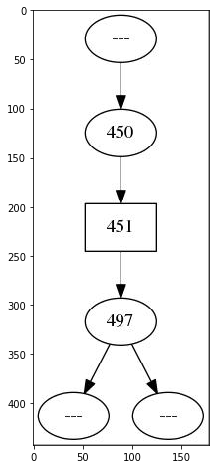

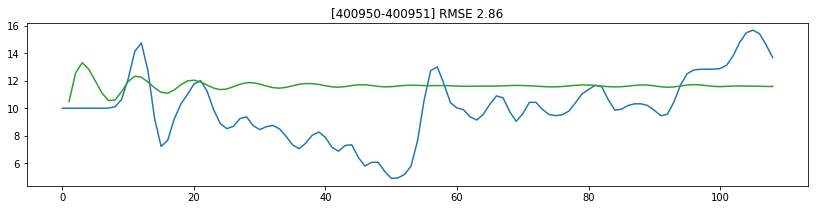

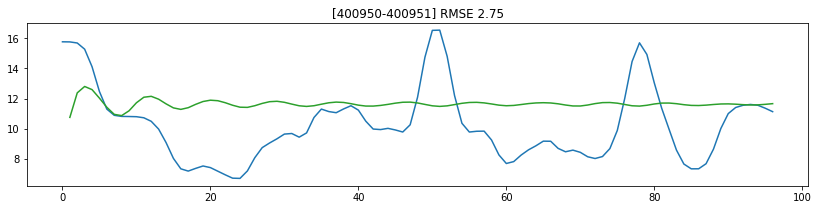

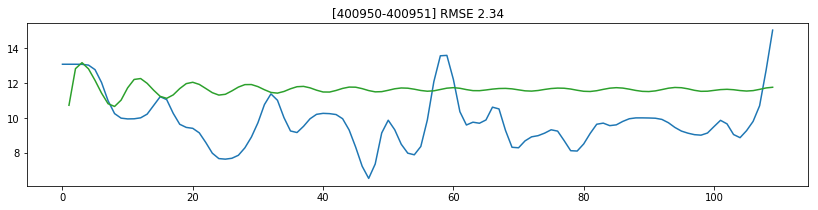

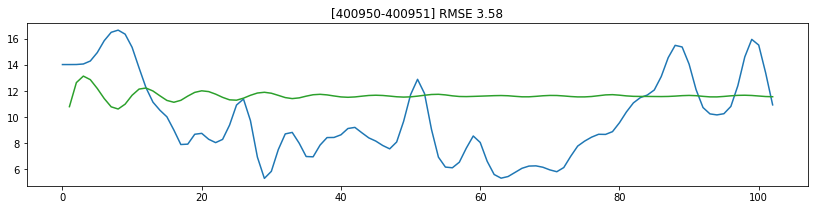

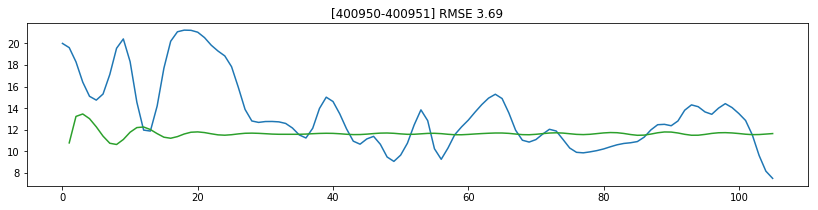

In [16]:
for ii in range(5):
    t0, tf = testset.trange[ii]
    
    _ = forecast_mprnn(
        testset[ii], model, graph_file, 
        twoway=True,
        verbose=ii is 0, plot=True)

In [ ]:
model.steps = len(SROUTE)
sqerr = eval_rnn(testset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(testset))
print('Eval MSE: %.4f' % np.mean(sqerr))

In [13]:
model.save()

Saving to: /home/ubuntu/datasets-aux/checkpoints/mpfcast/400950-400951_n2.pth
